In [22]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import io
import numpy as np
import time # Import the time module
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [35]:
from types import GenericAlias
class LinkPrediction:
    def __init__(self, G):
        self.G = G


    def analyze_network(self):
        """
        Phân tích và hiển thị các đặc trưng cơ bản của mạng
        """
        print("Number of nodes: ", self.G.number_of_nodes())
        print("Number of edges: ", self.G.number_of_edges())
        print("Clustering coefficient: ", {nx.average_clustering(self.G)})

        plt.figure(figsize=(15,5))

        #1. Vẽ cấu trúc mạng
        plt.subplot(131)
        pos = nx.spring_layout(self.G, seed = 42)
        nx.draw_networkx(self.G, pos, with_labels = True, node_color = 'lightblue', node_size=500, font_size=8)
        plt.title("Network Structure")

        #. Vẽ phân phối bậc
        plt.subplot(132)
        degree_sequence = [d for n, d in self.G.degree()]
        sns.histplot(degree_sequence, kde = True)
        plt.title("Degree Distribution")
        plt.xlabel("Degree")
        plt.ylabel("Frequency")

        #Vẽ phân phối hệ số clustering
        plt.subplot(133)
        clustering_coeff = list(nx.clustering(self.G).values())
        plt.hist(clustering_coeff, bins = 10, edgecolor = 'black')
        plt.title("Clustering Coefficient Distribution")
        plt.xlabel("Clustering Coefficient")
        plt.ylabel("Frequency")
        plt.show()


    def prepare_data(self):
        """
        Train/test: 80/20
        """
        #Lấy ra tất cả các cạnh trong đồ thị
        self.all_edges = list(self.G.edges())

        #Lấy tất cả các tập node không có cạnh và cân bằng số lượng mẫu
        self.all_non_edges = list(nx.non_edges(self.G))
        np.random.shuffle(self.all_non_edges)
        self.all_non_edges = self.all_non_edges[:len(self.all_edges)]

        #Chia thành train/test
        train_edges, test_edges = train_test_split(self.all_edges, test_size = 0.2, random_state = 42)
        train_non_edges, test_non_edges = train_test_split(self.all_non_edges, test_size = 0.2, random_state = 42)

        #Lưu lại để sử dụng
        self.train_edges = train_edges
        self.test_edges = test_edges
        self.train_non_edges = train_non_edges
        self.test_non_edges = test_non_edges

        print(f"Number of train edges: {len(self.train_edges)}, Number of test edges: {len(self.test_edges)}")
        print(f"Number of train non-edges: {len(self.train_non_edges)}, Number of test non-edges: {len(self.test_non_edges)}")
    def common_neighbors_score(self, u, v):
        """
        Tính điểm dựa trên số lượng láng giềng chung.
        """
        return len(list(nx.common_neighbors(self.G, u, v)))

    def jaccard_coefficient_score(self, u, v):
        """
        Tính hệ số Jaccard.
        """
        neighbors_u = set(self.G.neighbors(u))
        neighbors_v = set(self.G.neighbors(v))
        if len(neighbors_u | neighbors_v) == 0:
            return 0
        return len(neighbors_u & neighbors_v) / len(neighbors_u | neighbors_v)

    def adamic_adar_score(self, u, v):
        """
        Tính chỉ số Adamic/Adar.
        """
        return sum(1 / np.log(self.G.degree(w)) for w in nx.common_neighbors(self.G, u, v))

    def extract_features(self, edge_list):
        """
        Trích xuất đặc trưng cho các cạnh.
        """
        features = []
        for u, v in edge_list:
            features.append([
                self.common_neighbors_score(u, v),
                self.jaccard_coefficient_score(u, v),
                self.adamic_adar_score(u, v)
            ])
        return np.array(features)

    def visualize_prediction(self, test_pairs, predictions, title):
        """
        Vẽ đồ thị với các cạnh được dự đoán.
        - Xanh: Cạnh có sẵn trong đồ thị gốc
        - Đỏ: Cạnh được dự đoán là sẽ xuất hiện
        """
        plt.figure(figsize=(8, 8))
        pos = nx.spring_layout(self.G, seed=42)

        # Vẽ đồ thị gốc
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue',
                node_size=500, font_size=8, edge_color='green', width=1)

        # Vẽ các cạnh được dự đoán
        predicted_edges = [test_pairs[i] for i in range(len(predictions)) if predictions[i] == 1]
        nx.draw_networkx_edges(self.G, pos, edgelist=predicted_edges,
                              edge_color='red', style='dashed', width=2)

        plt.title(title)
        plt.show()
    def evaluate_methods(self):
        """
        Đánh giá các phương pháp dự đoán liên kết.
        """
        print("\n=== Đánh giá các phương pháp ===")
        # Chuẩn bị dữ liệu train
        X_train = self.extract_features(self.train_edges + self.train_non_edges)
        y_train = np.hstack([np.ones(len(self.train_edges)),
                            np.zeros(len(self.train_non_edges))])

        # Chuẩn bị dữ liệu test
        X_test = self.extract_features(self.test_edges + self.test_non_edges)
        y_test = np.hstack([np.ones(len(self.test_edges)),
                          np.zeros(len(self.test_non_edges))])

        test_pairs = self.test_edges + self.test_non_edges

        # Đánh giá từng phương pháp
        methods = ['Common Neighbors', 'Jaccard Coefficient', 'Adamic/Adar']
        results = []

        for i in range(3):
            # Tính ngưỡng từ tập train
            threshold = np.mean(X_train[:, i])

            # Dự đoán trên tập test
            predictions = (X_test[:, i] > threshold).astype(int)

            # Tính các metrics
            acc = accuracy_score(y_test, predictions)
            prec = precision_score(y_test, predictions)
            rec = recall_score(y_test, predictions)

            results.append({
                'Phương pháp': methods[i],
                'Accuracy': f"{acc:.3f}",
                'Precision': f"{prec:.3f}",
                'Recall': f"{rec:.3f}"
            })

            # Vẽ kết quả dự đoán cho mỗi phương pháp
            self.visualize_prediction(test_pairs, predictions,
                                    f'Dự đoán liên kết bằng {methods[i]}')

        # Vẽ bảng kết quả  # This block was incorrectly indented
        df_results = pd.DataFrame(results)
        plt.figure(figsize=(10, 3))
        plt.axis('off')
        table = plt.table(cellText=df_results.values,
                        colLabels=df_results.columns,
                        loc='center',
                        cellLoc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1.2, 1.5)
        plt.title('Bảng đánh giá các phương pháp')
        plt.show()

    def run_experiment(self):
        """
        Chạy toàn bộ thử nghiệm.
        """
        print("=== Bắt đầu thử nghiệm ===")
        self.analyze_network()  # Phân tích mạng
        self.prepare_data()     # Chuẩn bị dữ liệu
        self.evaluate_methods() # Đánh giá các phương pháp

=== Bắt đầu thử nghiệm ===
Number of nodes:  34
Number of edges:  78
Clustering coefficient:  {0.5706384782076823}


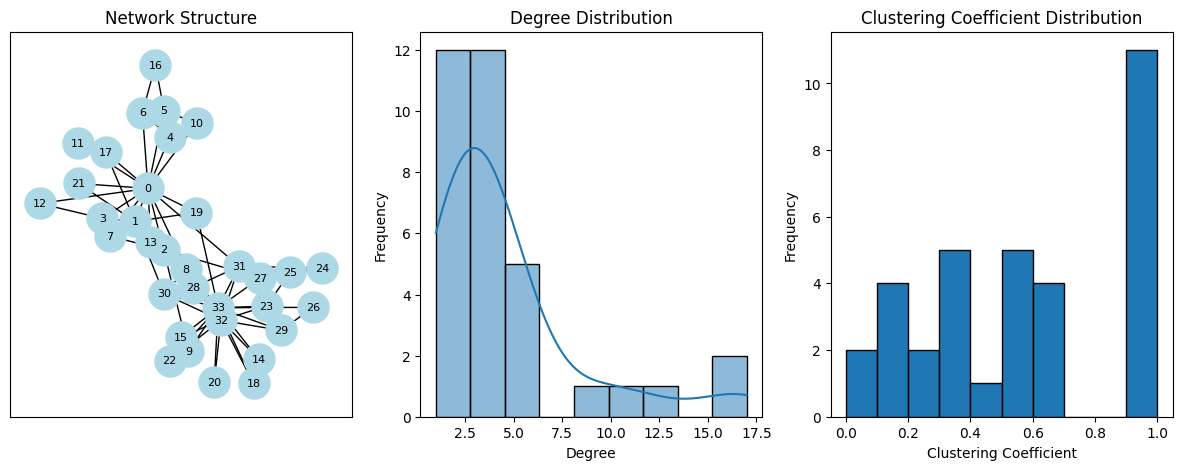

Number of train edges: 62, Number of test edges: 16
Number of train non-edges: 62, Number of test non-edges: 16

=== Đánh giá các phương pháp ===


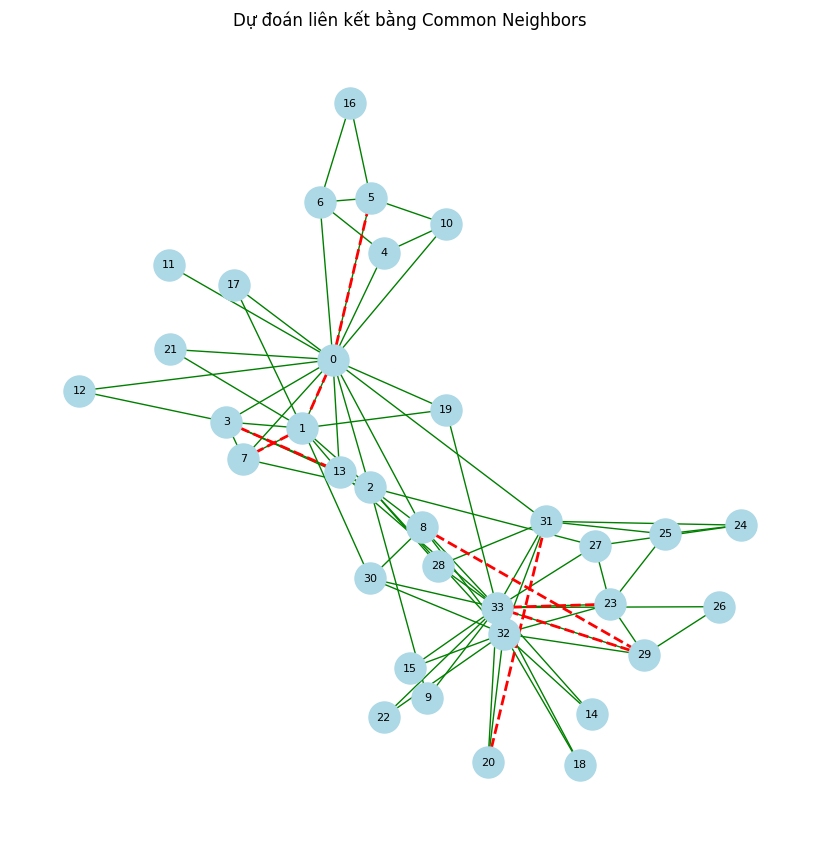

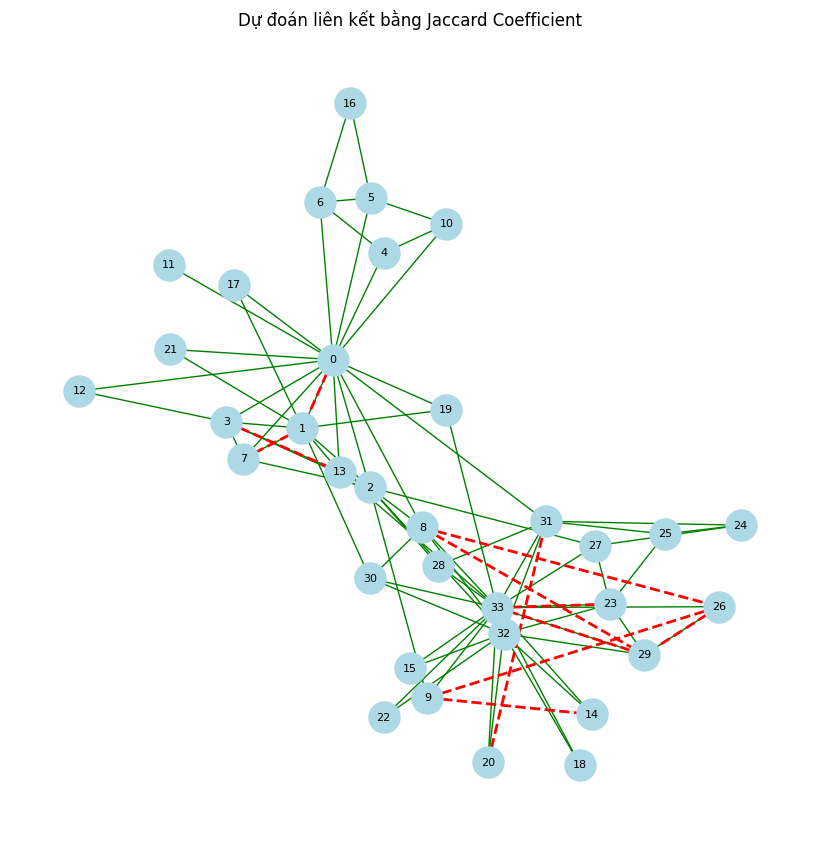

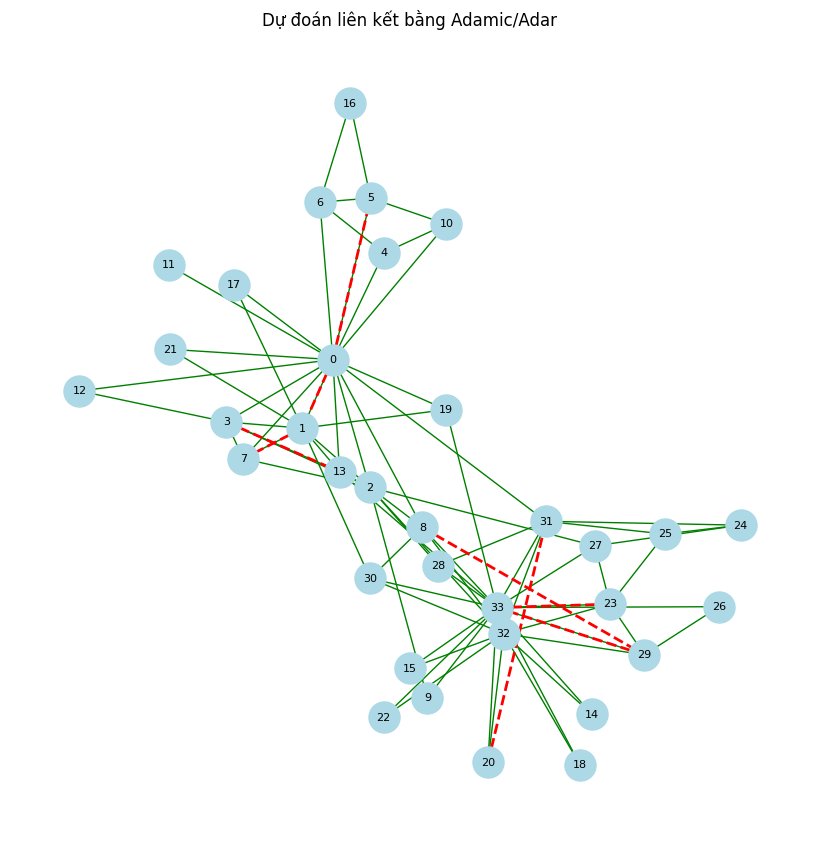

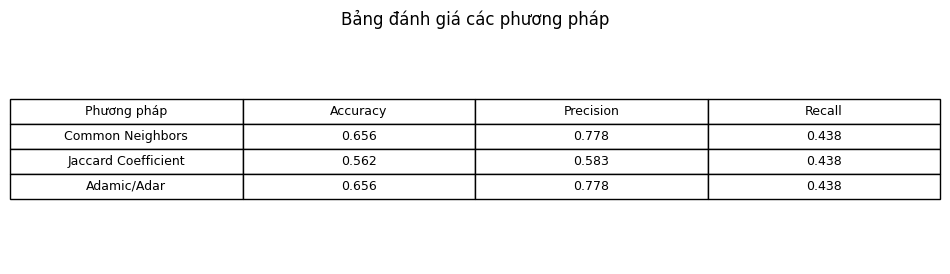

In [36]:
if __name__ == "__main__":
    G = nx.karate_club_graph()
    model = LinkPrediction(G)
    model.run_experiment()

# Test 3

In [28]:
!pip install torch torchvision torchaudio
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.4 MB/s eta 0:00:00


In [32]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GAE
from torch_geometric.utils import from_networkx, train_test_split_edges

In [33]:
class LinkPrediction:
    def __init__(self, G):
        self.G = G

    def analyze_network(self):
        """
        Phân tích và hiển thị các đặc trưng cơ bản của mạng
        """
        print("Number of nodes: ", self.G.number_of_nodes())
        print("Number of edges: ", self.G.number_of_edges())
        print("Clustering coefficient: ", nx.average_clustering(self.G))  # Sửa lỗi {}

        plt.figure(figsize=(15, 5))

        # 1. Vẽ cấu trúc mạng
        plt.subplot(131)
        pos = nx.spring_layout(self.G, seed=42)
        nx.draw_networkx(self.G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=8)
        plt.title("Network Structure")

        # 2. Vẽ phân phối bậc
        plt.subplot(132)
        degree_sequence = [d for n, d in self.G.degree()]
        sns.histplot(degree_sequence, kde=True)
        plt.title("Degree Distribution")
        plt.xlabel("Degree")
        plt.ylabel("Frequency")

        # 3. Vẽ phân phối hệ số clustering
        plt.subplot(133)
        clustering_coeff = list(nx.clustering(self.G).values())
        plt.hist(clustering_coeff, bins=10, edgecolor='black')
        plt.title("Clustering Coefficient Distribution")
        plt.xlabel("Clustering Coefficient")
        plt.ylabel("Frequency")
        plt.show()

    def prepare_data(self):
        """
        Train/test: 80/20
        """
        # Lấy ra tất cả các cạnh trong đồ thị
        self.all_edges = list(self.G.edges())

        # Lấy tất cả các tập node không có cạnh và cân bằng số lượng mẫu
        self.all_non_edges = list(nx.non_edges(self.G))
        np.random.shuffle(self.all_non_edges)

        # Sửa lỗi kiểm tra độ dài trước khi lấy mẫu
        self.all_non_edges = self.all_non_edges[:min(len(self.all_edges), len(self.all_non_edges))]

        # Chia thành train/test
        train_edges, test_edges = train_test_split(self.all_edges, test_size=0.2, random_state=42)
        train_non_edges, test_non_edges = train_test_split(self.all_non_edges, test_size=0.2, random_state=42)

        # Lưu lại để sử dụng
        self.train_edges = train_edges
        self.test_edges = test_edges
        self.train_non_edges = train_non_edges
        self.test_non_edges = test_non_edges

        print(f"Number of train edges: {len(self.train_edges)}, Number of test edges: {len(self.test_edges)}")
        print(f"Number of train non-edges: {len(self.train_non_edges)}, Number of test non-edges: {len(self.test_non_edges)}")

    def common_neighbors_score(self, u, v):
        """
        Tính điểm dựa trên số lượng láng giềng chung.
        """
        return len(list(nx.common_neighbors(self.G, u, v)))

    def jaccard_coefficient_score(self, u, v):
        """
        Tính hệ số Jaccard.
        """
        neighbors_u = set(self.G.neighbors(u))
        neighbors_v = set(self.G.neighbors(v))
        if len(neighbors_u | neighbors_v) == 0:
            return 0
        return len(neighbors_u & neighbors_v) / len(neighbors_u | neighbors_v)

    def adamic_adar_score(self, u, v):
        """
        Tính chỉ số Adamic/Adar.
        """
        # Sửa lỗi log(0)
        return sum(1 / np.log(self.G.degree(w)) for w in nx.common_neighbors(self.G, u, v) if self.G.degree(w) > 1)

    def extract_features(self, edge_list):
        """
        Trích xuất đặc trưng cho các cạnh.
        """
        features = []
        for u, v in edge_list:
            features.append([
                self.common_neighbors_score(u, v),
                self.jaccard_coefficient_score(u, v),
                self.adamic_adar_score(u, v)
            ])
        return np.array(features)

    def visualize_prediction(self, test_pairs, predictions, title):
        """
        Vẽ đồ thị với các cạnh được dự đoán.
        - Xanh: Cạnh có sẵn trong đồ thị gốc
        - Đỏ: Cạnh được dự đoán là sẽ xuất hiện
        """
        plt.figure(figsize=(8, 8))
        pos = nx.spring_layout(self.G, seed=42)

        # Vẽ đồ thị gốc
        nx.draw(self.G, pos, with_labels=True, node_color='lightblue',
                node_size=500, font_size=8, edge_color='green', width=1)

        # Vẽ các cạnh được dự đoán
        predicted_edges = [test_pairs[i] for i in range(len(predictions)) if predictions[i] == 1]
        nx.draw_networkx_edges(self.G, pos, edgelist=predicted_edges,
                               edge_color='red', style='dashed', width=2)

        plt.title(title)
        plt.show()

    def evaluate_methods(self):
        """
        Đánh giá các phương pháp dự đoán liên kết.
        """
        print("\n=== Đánh giá các phương pháp ===")
        # Chuẩn bị dữ liệu train
        X_train = self.extract_features(self.train_edges + self.train_non_edges)
        y_train = np.hstack([np.ones(len(self.train_edges)),
                             np.zeros(len(self.train_non_edges))])

        # Chuẩn bị dữ liệu test
        X_test = self.extract_features(self.test_edges + self.test_non_edges)
        y_test = np.hstack([np.ones(len(self.test_edges)),
                            np.zeros(len(self.test_non_edges))])

        test_pairs = self.test_edges + self.test_non_edges

        # Đánh giá từng phương pháp
        methods = ['Common Neighbors', 'Jaccard Coefficient', 'Adamic/Adar']
        results = []

        for i in range(3):
            # Tính ngưỡng từ tập train
            threshold = np.mean(X_train[:, i])

            # Dự đoán trên tập test
            predictions = (X_test[:, i] > threshold).astype(int)

            # Tính các metrics
            acc = accuracy_score(y_test, predictions)
            prec = precision_score(y_test, predictions)
            rec = recall_score(y_test, predictions)

            results.append({
                'Phương pháp': methods[i],
                'Accuracy': f"{acc:.3f}",
                'Precision': f"{prec:.3f}",
                'Recall': f"{rec:.3f}"
            })

            # Vẽ kết quả dự đoán cho mỗi phương pháp
            self.visualize_prediction(test_pairs, predictions,
                                      f'Dự đoán liên kết bằng {methods[i]}')

        # Vẽ bảng kết quả
        df_results = pd.DataFrame(results)
        print(df_results)  # In bảng thay vì vẽ bằng matplotlib

    def train_gnn(self, epochs=200, lr=0.01):
        """
        Huấn luyện mô hình GNN để dự đoán liên kết.
        """
        print("\n=== Đào tạo GNN ===")

        # Chuyển đổi đồ thị NetworkX sang PyTorch Geometric
        pyg_data = from_networkx(self.G)
        pyg_data = train_test_split_edges(pyg_data)

        # Định nghĩa mô hình GNN
        class GCN(torch.nn.Module):
            def __init__(self, in_channels, out_channels):
                super(GCN, self).__init__()
                self.conv1 = GCNConv(in_channels, 16)
                self.conv2 = GCNConv(16, out_channels)

            def encode(self, x, edge_index):
                x = self.conv1(x, edge_index).relu()
                x = self.conv2(x, edge_index)
                return x

            def decode(self, z, edge_index):
                return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=-1)

        # Tạo mô hình và optimizer
        model = GAE(GCN(pyg_data.num_features, 16))
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Huấn luyện mô hình
        model.train()
        for epoch in range(epochs):
            optimizer.zero_grad()
            z = model.encode(pyg_data.x, pyg_data.train_pos_edge_index)
            loss = model.recon_loss(z, pyg_data.train_pos_edge_index)
            loss.backward()
            optimizer.step()

            if epoch % 20 == 0:
                print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.4f}")

        # Đánh giá mô hình
        model.eval()
        z = model.encode(pyg_data.x, pyg_data.train_pos_edge_index)
        auc, ap = model.test(z, pyg_data.test_pos_edge_index, pyg_data.test_neg_edge_index)
        print(f"AUC: {auc:.4f}, AP: {ap:.4f}")

        self.model = model
        self.pyg_data = pyg_data

    def run_experiment(self):
        print("====Bắt đầu thử nghiệm====")
        self.analyze_network()
        self.prepare_data()
        self.evaluate_methods()
        self.train_gnn()  # Gọi GNN ở cuối thử nghiệm
        print("====Kết thúc thử nghiệm====")



====Bắt đầu thử nghiệm====
Number of nodes:  34
Number of edges:  78
Clustering coefficient:  0.5706384782076823


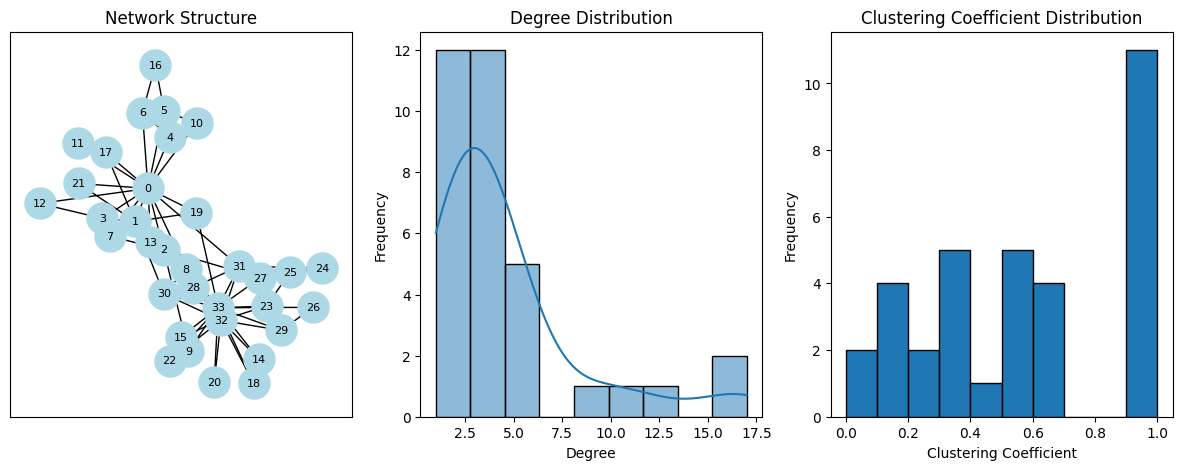

Number of train edges: 62, Number of test edges: 16
Number of train non-edges: 62, Number of test non-edges: 16

=== Đánh giá các phương pháp ===


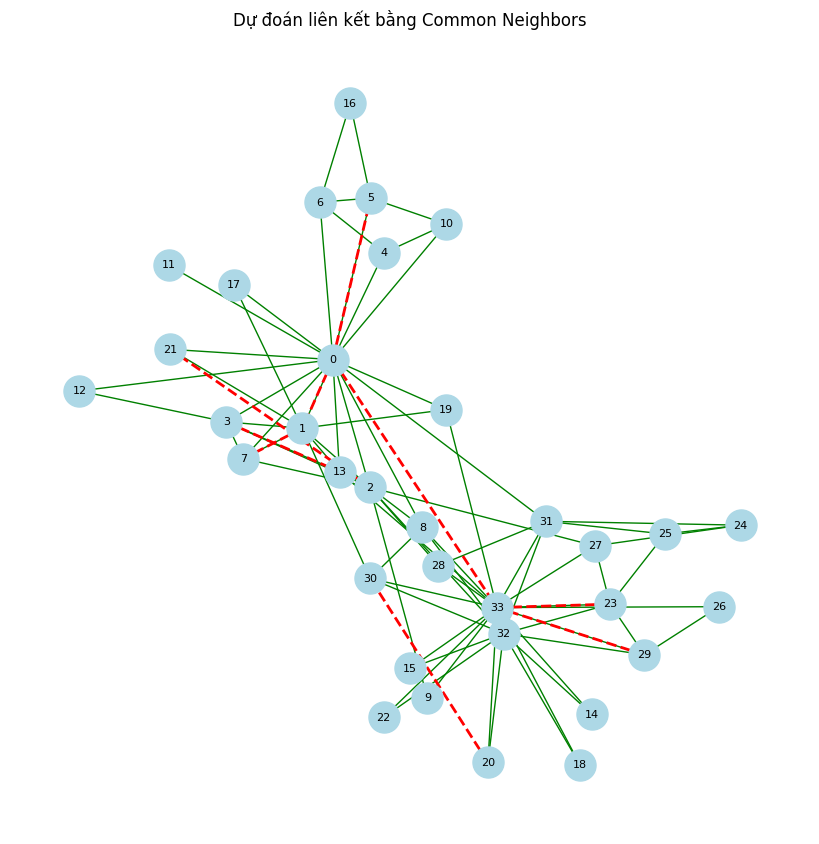

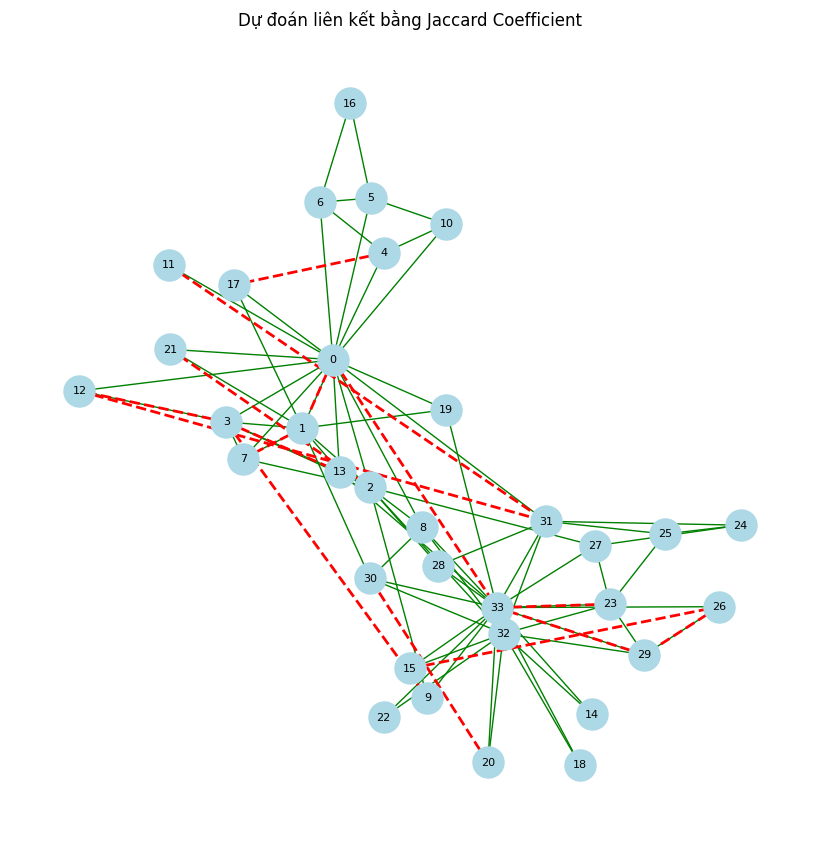

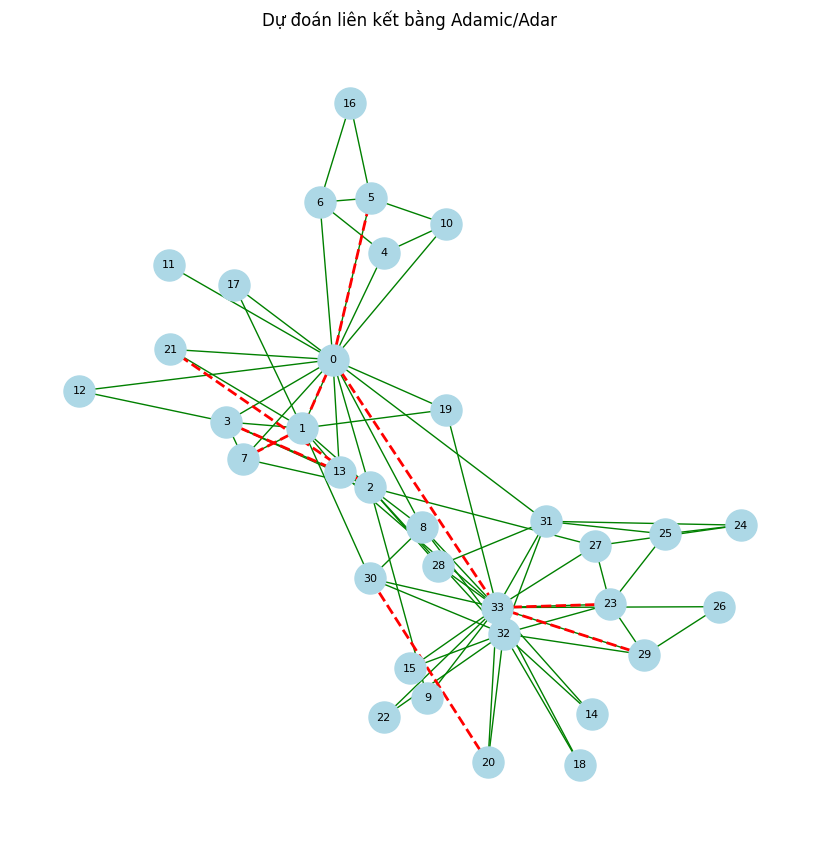

           Phương pháp Accuracy Precision Recall
0     Common Neighbors    0.625     0.700  0.438
1  Jaccard Coefficient    0.500     0.500  0.500
2          Adamic/Adar    0.625     0.700  0.438

=== Đào tạo GNN ===


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


NotImplementedError: Module [GCN] is missing the required "forward" function

In [34]:
if __name__ == "__main__":
    G = nx.karate_club_graph()
    model = LinkPrediction(G)
    model.run_experiment()